In [1]:
import pyBigWig
import pandas as pd
import numpy as np
import deepdish as dd
import os
import pyfaidx
import random
import pickle as pkl
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import json
import one_hot as dinuc_shuffle_main
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

In [2]:
regions = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/IMR90/negatives_data/negatives_with_summit.bed"
genome = "/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa"

In [4]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)


def get_footprint_for_motif(seqs, motif, model, inputlen, batch_size):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    w_mot_seqs = seqs.copy()
    w_mot_seqs[:, midpoint-len(motif)//2:midpoint-len(motif)//2+len(motif)] =dinuc_shuffle_main.dna_to_one_hot([motif])

    # midpoint of motif is the midpoint of sequence
    pred_output=model.predict(w_mot_seqs, batch_size=batch_size, verbose=True)
    footprint_for_motif_fwd = softmax(pred_output[0])*(np.exp(pred_output[1])-1)

    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]
    pred_output_rev=model.predict(w_mot_seqs_revc, batch_size=batch_size, verbose=True)
    footprint_for_motif_rev = softmax(pred_output_rev[0])*(np.exp(pred_output_rev[1])-1)

    # add fwd sequence predictions and reverse sesquence predictions (not we flip the rev predictions)
    counts_for_motif = (np.exp(pred_output_rev[1]) - 1 + np.exp(pred_output[1]) - 1)/2
    footprint_for_motif_tot = (footprint_for_motif_fwd+footprint_for_motif_rev[:,::-1])/2
    footprint_for_motif =  footprint_for_motif_tot / footprint_for_motif_tot.sum(axis=1)[:, np.newaxis]
    k_l=1000
    # if counts_for_motif.shape[0] > k_l:
    #     print(counts_for_motif.shape)
    #     smallest_100 = np.argpartition(counts_for_motif[:,0], k_l)[:k_l]
    #     return footprint_for_motif_tot[smallest_100].mean(0), counts_for_motif[smallest_100].mean(0), smallest_100
    # else:
    return footprint_for_motif.mean(0), counts_for_motif.mean(0), None

def get_footprint_for_two_motifs(seqs, motifs, model, inputlen, batch_size, spacing):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    spacing_per_motif = spacing // 2
    
    w_mot_seqs = seqs.copy()
    
    motif = motifs[0]
    start = midpoint-(len(motif)//2)
    w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    print(motif,start,start+len(motif))
    if spacing > 0:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start+len(motifs[0])+spacing_per_motif 
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    else:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start + spacing_per_motif - len(motif)
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    

    # midpoint of motif is the midpoint of sequence
    pred_output=model.predict(w_mot_seqs, batch_size=batch_size, verbose=True)
    footprint_for_motif_fwd = softmax(pred_output[0])*(np.exp(pred_output[1])-1)

    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]
    pred_output_rev=model.predict(w_mot_seqs_revc, batch_size=batch_size, verbose=True)
    footprint_for_motif_rev = softmax(pred_output_rev[0])*(np.exp(pred_output_rev[1])-1)

    # add fwd sequence predictions and reverse sesquence predictions (not we flip the rev predictions)
    counts_for_motif = (np.exp(pred_output_rev[1]) - 1 + np.exp(pred_output[1]) - 1)/2
    footprint_for_motif_tot = (footprint_for_motif_fwd+footprint_for_motif_rev[:,::-1])/2
    footprint_for_motif =  footprint_for_motif_tot / footprint_for_motif_tot.sum(axis=1)[:, np.newaxis]

    return footprint_for_motif.mean(0), counts_for_motif.mean(0)

In [5]:
def get_seq(peaks_df, genome, width, shuffle=False):
    """
    fetches sequence from a given genome.
    """
    vals = []

    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
                vals.append(sequence)

    return dinuc_shuffle_main.dna_to_one_hot(vals)

In [6]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
inputlen = 2114
np.random.seed(0)
regions_df = pd.read_csv(regions, sep='\t', names=NARROWPEAK_SCHEMA)
# regions_subsample = regions_df
index_ids = np.random.choice(regions_df.shape[0], 100, replace=False)
regions_subsample = regions_df.iloc[index_ids].reset_index()

genome_fasta = pyfaidx.Fasta(genome)
regions_seqs = get_seq(regions_subsample, genome_fasta, inputlen)

In [7]:
data = pd.read_csv("/mnt/lab_data2/anusri/chrombpnet/logs/checkpoint/JAN_02_2023/model_dir_atac.csv",header=None)
cell_type="IMR90"
ndata = data[data[1]==cell_type].reset_index()

In [8]:
motif =  ""
batch_size=128
k_l=100
motifs_footprint = {}
motifs_counts = {} 
for i,r in ndata.iterrows():
    print(i)
    if i==0:
        mdl_path1 = os.path.join(r[2],"chrombpnet_model/new_model_formats/chrombpnet_wo_bias")
        if not os.path.exists(mdl_path1):
            break
        
        model=load_model(mdl_path1, compile=False)
        print(regions_seqs.shape)
        full_footprint_1 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
        # regions_seqs = regions_seqs[full_footprint_1[2],:,:]
        # print(regions_seqs.shape)
        motifs_footprint["control"] = full_footprint_1[0]
        motifs_counts["control"] = full_footprint_1[1]
    else:
        mdl_path1 = os.path.join(r[2],"chrombpnet_model/new_model_formats/chrombpnet_wo_bias")
        model=load_model(mdl_path1, compile=False)
        full_footprint_1 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
        motifs_footprint["control"] += full_footprint_1[0]
        motifs_counts["control"] += full_footprint_1[1]
        
motifs_footprint["control"] = motifs_footprint["control"]/5  
motifs_counts["control"] = motifs_counts["control"] / 5

0


2024-02-05 12:19:37.098051: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 12:19:38.104946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11424 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:5e:00.0, compute capability: 6.1


(100, 2114, 4)


2024-02-05 12:19:41.469478: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


1/1 [==============================] - 0s 64ms/step
1
1/1 [==============================] - 0s 42ms/step
2
1/1 [==============================] - 0s 44ms/step
3
1/1 [==============================] - 0s 64ms/step
4
1/1 [==============================] - 0s 65ms/step


In [9]:
motif="AGGAATGT"
batch_size=128

for i,r in ndata.iterrows():
    print(i)
    mdl_path1 = os.path.join(r[2],"chrombpnet_model/new_model_formats/chrombpnet_wo_bias")
    model=load_model(mdl_path1, compile=False)
    full_footprint_1 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
    if i==0:
        motifs_footprint["TEAD"] = full_footprint_1[0]
        motifs_counts["TEAD"] = full_footprint_1[1]
    else:
        motifs_footprint["TEAD"] += full_footprint_1[0]
        motifs_counts["TEAD"] += full_footprint_1[1]

motifs_footprint["TEAD"] =  motifs_footprint["TEAD"] / 5
motifs_counts["TEAD"] = motifs_counts["TEAD"] / 5

0
1/1 [==============================] - 0s 49ms/step
1
1/1 [==============================] - 0s 45ms/step
2
1/1 [==============================] - 0s 54ms/step
3
1/1 [==============================] - 0s 47ms/step
4
1/1 [==============================] - 0s 51ms/step


In [10]:
motif = "TTGACTCA"

batch_size=128

for i,r in ndata.iterrows():
    print(i)
    mdl_path1 = os.path.join(r[2],"chrombpnet_model/new_model_formats/chrombpnet_wo_bias")
    model=load_model(mdl_path1, compile=False)
    full_footprint_1 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
    if i==0:
        motifs_footprint["AP1"] = full_footprint_1[0]
        motifs_counts["AP1"] = full_footprint_1[1]
    else:
        motifs_footprint["AP1"] += full_footprint_1[0]
        motifs_counts["AP1"] += full_footprint_1[1]

motifs_footprint["AP1"] =  motifs_footprint["AP1"] / 5
motifs_counts["AP1"] = motifs_counts["AP1"] / 5

0
1/1 [==============================] - 0s 46ms/step
1
1/1 [==============================] - 0s 43ms/step
2
1/1 [==============================] - 0s 45ms/step
3
1/1 [==============================] - 0s 58ms/step
4
1/1 [==============================] - 0s 45ms/step


In [11]:
motifs = ["AGGAATGT","TTGACTCA"]

data_in_spacings = []
counts_in_spacings = []
for spacing in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]:
    for i,r in ndata.iterrows():
        print(i)
        mdl_path1 = os.path.join(r[2],"chrombpnet_model/new_model_formats/chrombpnet_wo_bias")
        model=load_model(mdl_path1, compile=False)
        full_footprint_1 = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=-1*spacing)
        if i==0:
            init_spacing_1 = full_footprint_1[0]
            init_spacing_2 = full_footprint_1[1]
        else:
            init_spacing_1 += full_footprint_1[0]
            init_spacing_2 += full_footprint_1[1]
    init_spacing_1 = init_spacing_1/5
    init_spacing_2 = init_spacing_2/5
    data_in_spacings.append(init_spacing_1)
    counts_in_spacings.append(init_spacing_2)
    del init_spacing_1

0
AGGAATGT 1053 1061
1/1 [==============================] - 0s 44ms/step
1
AGGAATGT 1053 1061
1/1 [==============================] - 0s 69ms/step
2
AGGAATGT 1053 1061
1/1 [==============================] - 0s 45ms/step
3
AGGAATGT 1053 1061
1/1 [==============================] - 0s 46ms/step
4
AGGAATGT 1053 1061
1/1 [==============================] - 0s 43ms/step
0
AGGAATGT 1053 1061
1/1 [==============================] - 0s 50ms/step
1
AGGAATGT 1053 1061
1/1 [==============================] - 0s 47ms/step
2
AGGAATGT 1053 1061
1/1 [==============================] - 0s 45ms/step
3
AGGAATGT 1053 1061
1/1 [==============================] - 0s 42ms/step
4
AGGAATGT 1053 1061
1/1 [==============================] - 0s 43ms/step
0
AGGAATGT 1053 1061
1/1 [==============================] - 0s 42ms/step
1
AGGAATGT 1053 1061
1/1 [==============================] - 0s 49ms/step
2
AGGAATGT 1053 1061
1/1 [==============================] - 0s 46ms/step
3
AGGAATGT 1053 1061
1/1 [=========================

In [12]:
motifs = ["AGGAATGT","TTGACTCA"]

data_in_spacings_rev = []
counts_in_spacings_rev = []
for spacing in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]:
    for i,r in ndata.iterrows():
        print(i)
        mdl_path1 = os.path.join(r[2],"chrombpnet_model/new_model_formats/chrombpnet_wo_bias")
        model=load_model(mdl_path1, compile=False)
        full_footprint_1 = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=spacing)
        if i==0:
            init_spacing_1 = full_footprint_1[0]
            init_spacing_2 = full_footprint_1[1]
        else:
            init_spacing_1 += full_footprint_1[0]
            init_spacing_2 += full_footprint_1[1]
    init_spacing_1 = init_spacing_1/5
    init_spacing_2 = init_spacing_2/5
    data_in_spacings_rev.append(init_spacing_1)
    counts_in_spacings_rev.append(init_spacing_2)
    del init_spacing_1

0
AGGAATGT 1053 1061
1/1 [==============================] - 0s 46ms/step
1
AGGAATGT 1053 1061
1/1 [==============================] - 0s 45ms/step
2
AGGAATGT 1053 1061
1/1 [==============================] - 0s 49ms/step
3
AGGAATGT 1053 1061
1/1 [==============================] - 0s 48ms/step
4
AGGAATGT 1053 1061
1/1 [==============================] - 0s 42ms/step
0
AGGAATGT 1053 1061
1/1 [==============================] - 0s 53ms/step
1
AGGAATGT 1053 1061
1/1 [==============================] - 0s 43ms/step
2
AGGAATGT 1053 1061
1/1 [==============================] - 0s 41ms/step
3
AGGAATGT 1053 1061
1/1 [==============================] - 0s 45ms/step
4
AGGAATGT 1053 1061
1/1 [==============================] - 0s 44ms/step
0
AGGAATGT 1053 1061
1/1 [==============================] - 0s 49ms/step
1
AGGAATGT 1053 1061
1/1 [==============================] - 0s 46ms/step
2
AGGAATGT 1053 1061
1/1 [==============================] - 0s 42ms/step
3
AGGAATGT 1053 1061
1/1 [=========================

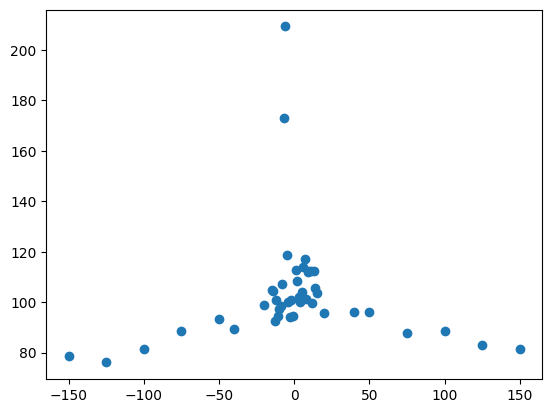

In [13]:
all_counts = counts_in_spacings
all_counts_rev = counts_in_spacings_rev


plt.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40, -50, -75, -100, -125, -150],all_counts_rev+all_counts)


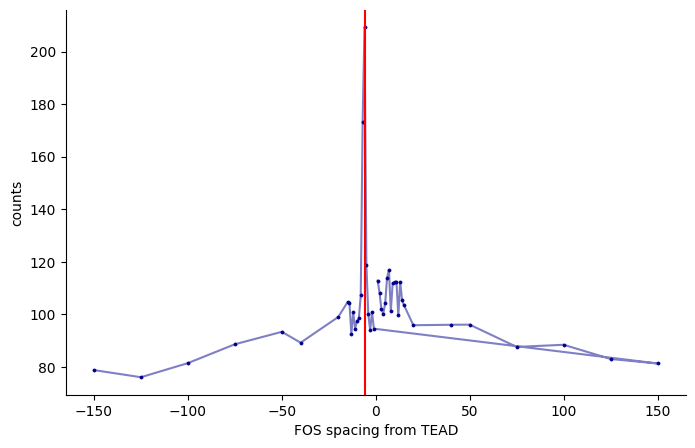

In [29]:

from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40, -50, -75, -100, -125, -150],all_counts_rev[0:]+all_counts[0:], linewidths=0.5, edgecolors=None,s=5, c="#00008B")
ax.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40, -50, -75, -100, -125, -150],all_counts_rev[0:]+all_counts[0:], alpha=0.5 , c="#00008B")

# Dataset
# x = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40, -50, -75, -100, -125, -150])
# y = np.array(all_counts[::-1]+all_counts_rev)

#X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
# X_ = np.linspace(x.min(), x.max(), 500)
#Y_ = X_Y_Spline(X_)

ax.axvline(-6, color="orange", linestyle="-", c="red")  #vertical line
#plt.plot(X_,Y_)
ax.set_ylabel("counts")
ax.set_xlabel("FOS spacing from TEAD")
ax.spines[['right', 'top']].set_visible(False)

plt.savefig("subfigs/ap1_tead_syntax_atac.pdf", transparent=True, dpi=300)



In [19]:
np.argmax(all_counts_rev[0:]+all_counts[0:])


27

In [20]:
[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150][16]

40

In [21]:
y=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40, -50, -75, -100, -125, -150]
y[27]




-6